<a href="https://colab.research.google.com/github/El-Do-RaDo/wine-variety-prediction/blob/master/wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
import pandas as pd
import os
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import numpy as np
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, Input, Activation, CuDNNGRU, Bidirectional, Dropout, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
%matplotlib inline

In [3]:
upload = files.upload()

Saving train.csv to train (1).csv


In [4]:
data = pd.read_csv('train (1).csv')
data.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [0]:

data.rename(columns = {'review_description':'description'}, inplace = True) 

In [7]:
data.columns

Index(['user_name', 'country', 'review_title', 'description', 'designation',
       'points', 'price', 'province', 'region_1', 'region_2', 'winery',
       'variety'],
      dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_name     63264 non-null  object 
 1   country       82622 non-null  object 
 2   review_title  82657 non-null  object 
 3   description   82657 non-null  object 
 4   designation   59010 non-null  object 
 5   points        82657 non-null  int64  
 6   price         77088 non-null  float64
 7   province      82622 non-null  object 
 8   region_1      69903 non-null  object 
 9   region_2      35949 non-null  object 
 10  winery        82657 non-null  object 
 11  variety       82657 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [15]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

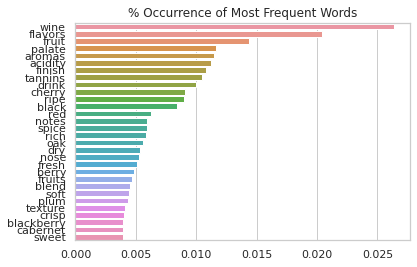

In [16]:

sns.set(style="whitegrid")

stopwords = set(stopwords.words('english'))
detokenizer = TreebankWordDetokenizer()

def clean_description(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)

data["cleaned_description"] = data["description"].apply(clean_description)

word_occurrence = data["cleaned_description"].str.split(expand=True).stack().value_counts()

total_words = sum(word_occurrence)



top_words = word_occurrence[:30]/total_words

ax = sns.barplot(x = top_words.values, y = top_words.index)


ax.set_title("% Occurrence of Most Frequent Words")

plt.show()

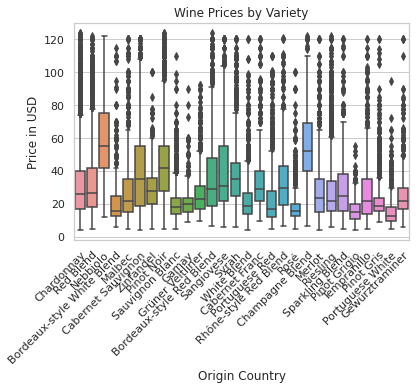

In [11]:
prices_by_variety = data[["price", "variety"]].dropna(how = "any")


val = prices_by_variety["price"].quantile(0.98)
prices_by_variety = prices_by_variety[prices_by_variety["price"] < val]


prices_by_variety = prices_by_variety.groupby("variety").filter(lambda x: (x["price"].count() >= 500))


ax = sns.boxplot(x="variety", y = "price", data=prices_by_variety)


ax.set_title("Wine Prices by Variety")


ax.set(xlabel = "Origin Country", ylabel = "Price in USD")


ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

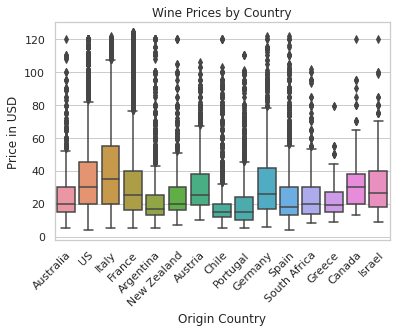

In [12]:
prices_by_country = data[["price", "country"]].dropna(how = "any")


val = prices_by_country["price"].quantile(0.98)
prices_by_country = prices_by_country[prices_by_country["price"] < val]


prices_by_country = prices_by_country.groupby("country").filter(lambda x: (x["price"].count() >= 100))


ax = sns.boxplot(x="country", y = "price", data=prices_by_country)


ax.set_title("Wine Prices by Country")


ax.set(xlabel = "Origin Country", ylabel = "Price in USD")


ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

In [25]:
lst = data['variety'].unique()
lst

array(['Chardonnay', 'Red Blend', 'Nebbiolo',
       'Bordeaux-style White Blend', 'Malbec', 'Cabernet Sauvignon',
       'Zinfandel', 'Pinot Noir', 'Sauvignon Blanc', 'Gamay',
       'Grüner Veltliner', 'Bordeaux-style Red Blend', 'Sangiovese',
       'Syrah', 'White Blend', 'Cabernet Franc', 'Portuguese Red',
       'Portuguese White', 'Rhône-style Red Blend', 'Rosé',
       'Champagne Blend', 'Merlot', 'Riesling', 'Sparkling Blend',
       'Pinot Grigio', 'Tempranillo', 'Pinot Gris', 'Gewürztraminer'],
      dtype=object)

In [0]:
keys = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
dict = {key: lst[key] for key in keys}

In [0]:
def points_to_class(variety):
    for key, value in dict.items():
        if value == variety:
            return key
    

data['class'] = data['variety'].apply(points_to_class)

In [64]:
data['class'].value_counts()

7.0     10587
0.0      9403
5.0      7552
1.0      7166
11.0     5497
22.0     4148
8.0      4011
13.0     3316
19.0     2831
21.0     2471
2.0      2242
6.0      2209
12.0     2165
16.0     1969
14.0     1896
23.0     1739
25.0     1448
18.0     1182
26.0     1148
20.0     1133
15.0     1095
10.0     1055
17.0      896
24.0      873
3.0       850
27.0      840
9.0       816
Name: class, dtype: int64

In [0]:
num_classes = 28
embedding_dim = 300 
epochs = 100
batch_size = 128
max_len = 100

class_weights = {0: 1,
                1: 1,
                2: 1, 
                3: 7,
                4: 1,
                5: 1,
                 6: 1,
                7: 1,
                8: 1, 
                9: 7,
                10: 1,
                11: 1,
                 12: 1,
                13: 1,
                14: 1, 
                15: 1,
                16: 1,
                17: 7,
                 18: 1,
                19: 1,
                20: 1, 
                21: 1,
                22: 1,
                23: 1,
                 24: 7,
                25: 1,
                26: 1, 
                27: 7}

In [0]:


def onehot(arr, num_class):
    return np.eye(num_class)[np.array(arr.astype(int)).reshape(-1)]

y = onehot(data["class"], num_classes)


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data["description"], y, test_size = 0.05)




embeddings_index = {}

f = open("glove.840B.300d.txt", encoding = "utf8")

for line in f:
    values = line.split()
    word = ''.join(values[:-embedding_dim])
    coefs = np.asarray(values[-embedding_dim:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
    

tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(X_train)


sequences_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences_train, maxlen=max_len)


sequences_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(sequences_val, maxlen = max_len)

word_index = tokenizer.word_index

word_index = tokenizer.word_index
                

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
        
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False) 
input= Input(shape=(max_len, ), dtype = 'int32')
embedded_sequences = embedding_layer(input) 
x = Bidirectional(CuDNNGRU(50, return_sequences=True))(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation = 'relu')(x)
x = Dropout(0.1)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input, outputs=output)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
callback = [checkpoint, early]
        
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=callback, class_weight = class_weights)

In [0]:
test = pd.read_csv("test.csv")
test["rating"] = test["points"].apply(points_to_class)

sequences_test = tokenizer.texts_to_sequences(test["description"])
X_test = pad_sequences(sequences_test, maxlen=max_len)


pred_test = model.predict(X_test)
pred_test = [np.argmax(x) for x in pred_test]


true_test = onehot(test["rating"], num_classes)
true_test = [np.argmax(x) for x in true_test]


accuracy = accuracy_score(true_test, pred_test)